Number of classes: 4
Classes: ['elephant', 'giraffe', 'lion', 'zebra']


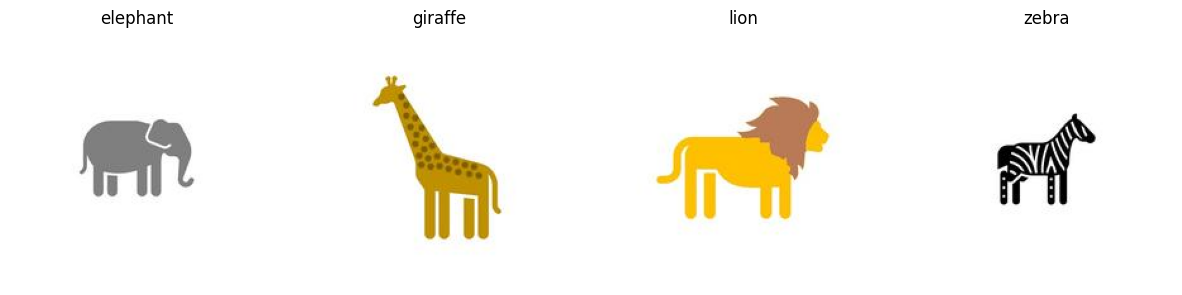

In [1]:
import os 
import sys
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
import numpy as np

base_path = r'C:\Users\colka\OneDrive\Documents\WebStore\data\datasources\challenges\data\safari\training'
classes = os.listdir(base_path)

print(f"Number of classes: {len(classes)}")
print("Classes:", classes)

fig = plt.figure(figsize=(15, 8))

for idx, class_name in enumerate(classes):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)
    
    if image_files:  # Ensure the folder isn't empty
        img_path = os.path.join(class_path, image_files[0])
        img = mpimg.imread(img_path)
        
        ax = fig.add_subplot(1, len(classes), idx + 1)
        ax.set_title(class_name)
        ax.imshow(img)
        ax.axis('off')

plt.show()


In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))
])

train_data = datasets.ImageFolder(base_path, transform=transform)
train_subset, val_subset = random_split(train_data, [int(len(train_data)*.6), len(train_data) - int(len(train_data)*.6)])
train_loader = DataLoader(train_subset, batch_size=25, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=25, shuffle=False)
print("Classes:" ,train_data.classes)

Classes: ['elephant', 'giraffe', 'lion', 'zebra']


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = SimpleCNN(num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
for epoch in range (15):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs= model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch +1}, {i +1}] loss: {running_loss /10:.3f}")
            running_loss = 0.0

torch.save(model.state_dict(), "torch_safari_cnn.pth")

[1, 10] loss: 1.116
[2, 10] loss: 0.407
[3, 10] loss: 0.078
[4, 10] loss: 0.020
[5, 10] loss: 0.006
[6, 10] loss: 0.008
[7, 10] loss: 0.006
[8, 10] loss: 0.003
[9, 10] loss: 0.001
[10, 10] loss: 0.018
[11, 10] loss: 0.007
[12, 10] loss: 0.005
[13, 10] loss: 0.005
[14, 10] loss: 0.003
[15, 10] loss: 0.003


In [4]:
model = SimpleCNN(num_classes=len(classes))
model.load_state_dict(torch.load("torch_safari_cnn.pth"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

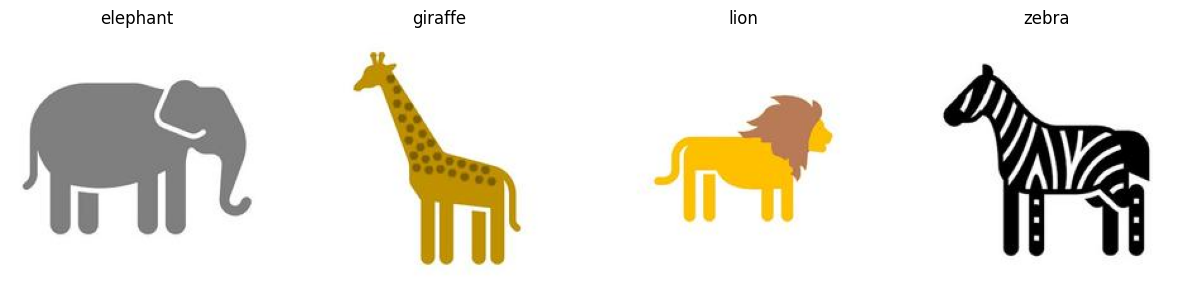

In [5]:
from PIL import Image

test_path = r'C:\Users\colka\OneDrive\Documents\WebStore\data\datasources\challenges\data\safari\test'

def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    outputs = model(image)
    predicted_class = torch.argmax(outputs, 1).item()
    return train_data.classes[predicted_class]

fig = plt.figure(figsize=(15,8))

for idx,image in enumerate(os.listdir(test_path)):
    image_path = os.path.join(test_path, image)
    
    ax = fig.add_subplot(1,len(os.listdir(test_path)), idx + 1)
    ax.set_title(predict_image(image_path))
    ax.imshow(Image.open(image_path))
    ax.axis('off')
plt.show()


In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Training Accuracy: {100 * correct / total:.2f}%")

Training Accuracy: 100.00%
